![A soccer pitch for an international match.](soccer-pitch.jpg)

You're working as a sports journalist at a major online sports media company, specializing in soccer analysis and reporting. You've been watching both men's and women's international soccer matches for a number of years, and your gut instinct tells you that more goals are scored in women's international football matches than men's. This would make an interesting investigative article that your subscribers are bound to love, but you'll need to perform a valid statistical hypothesis test to be sure!

While scoping this project, you acknowledge that the sport has changed a lot over the years, and performances likely vary a lot depending on the tournament, so you decide to limit the data used in the analysis to only official `FIFA World Cup` matches (not including qualifiers) since `2002-01-01`.

You create two datasets containing the results of every official men's and women's international football match since the 19th century, which you scraped from a reliable online source. This data is stored in two CSV files: `women_results.csv` and `men_results.csv`.

The question you are trying to determine the answer to is:

> Are more goals scored in women's international soccer matches than men's?

You assume a **10% significance level**, and use the following null and alternative hypotheses:

$H_0$ : The mean number of goals scored in women's international soccer matches is the same as men's.

$H_A$ : The mean number of goals scored in women's international soccer matches is greater than men's.

In [132]:
# Start your code here!
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin
from scipy.stats import mannwhitneyu

In [133]:
# Load men's and women's datasets
men = pd.read_csv("men_results.csv")
women = pd.read_csv("women_results.csv")

In [134]:
men.head()

,Unnamed: 0,date,home_team,away_team,home_score,away_score,tournament
0,0,1872-11-30,Scotland,England,0,0,Friendly
1,1,1873-03-08,England,Scotland,4,2,Friendly
2,2,1874-03-07,Scotland,England,2,1,Friendly
3,3,1875-03-06,England,Scotland,2,2,Friendly
4,4,1876-03-04,Scotland,England,3,0,Friendly


In [135]:
women.head()

,Unnamed: 0,date,home_team,away_team,home_score,away_score,tournament
0,0,1969-11-01,Italy,France,1,0,Euro
1,1,1969-11-01,Denmark,England,4,3,Euro
2,2,1969-11-02,England,France,2,0,Euro
3,3,1969-11-02,Italy,Denmark,3,1,Euro
4,4,1975-08-25,Thailand,Australia,3,2,AFC Championship


In [136]:
# Filter the data for the time range and tournament
men["date"] = pd.to_datetime(men["date"])
men_subset = men[(men["date"] > "2002-01-01") & (men["tournament"].isin(["FIFA World Cup"]))]
women["date"] = pd.to_datetime(women["date"])
women_subset = women[(women["date"] > "2002-01-01") & (women["tournament"].isin(["FIFA World Cup"]))]

In [137]:
men_subset.head()

,Unnamed: 0,date,home_team,away_team,home_score,away_score,tournament
25164,25164,2002-05-31,France,Senegal,0,1,FIFA World Cup
25165,25165,2002-06-01,Germany,Saudi Arabia,8,0,FIFA World Cup
25166,25166,2002-06-01,Republic of Ireland,Cameroon,1,1,FIFA World Cup
25167,25167,2002-06-01,Uruguay,Denmark,1,2,FIFA World Cup
25168,25168,2002-06-02,Argentina,Nigeria,1,0,FIFA World Cup


In [138]:
# Create group and goals_scored columns
men_subset["group"] = "men"
women_subset["group"] = "women"
men_subset["goals_scored"] = men_subset["home_score"] + men_subset["away_score"]
women_subset["goals_scored"] = women_subset["home_score"] + women_subset["away_score"]

In [139]:
men_subset.head()

,Unnamed: 0,date,home_team,away_team,home_score,away_score,tournament,group,goals_scored
25164,25164,2002-05-31,France,Senegal,0,1,FIFA World Cup,men,1
25165,25165,2002-06-01,Germany,Saudi Arabia,8,0,FIFA World Cup,men,8
25166,25166,2002-06-01,Republic of Ireland,Cameroon,1,1,FIFA World Cup,men,2
25167,25167,2002-06-01,Uruguay,Denmark,1,2,FIFA World Cup,men,3
25168,25168,2002-06-02,Argentina,Nigeria,1,0,FIFA World Cup,men,1


<AxesSubplot: xlabel='goals_scored', ylabel='Count'>

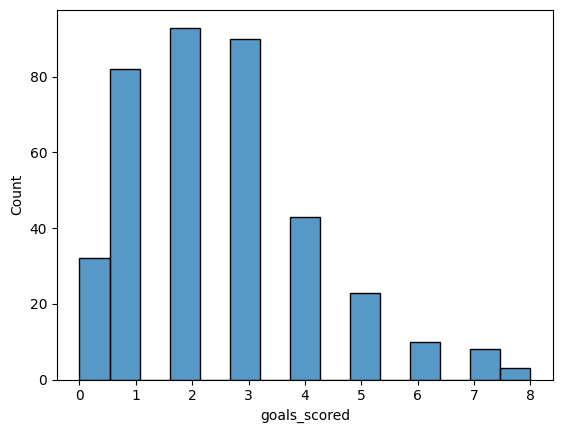

In [140]:
sns.histplot(data=men_subset, x="goals_scored")#, hue="trx")

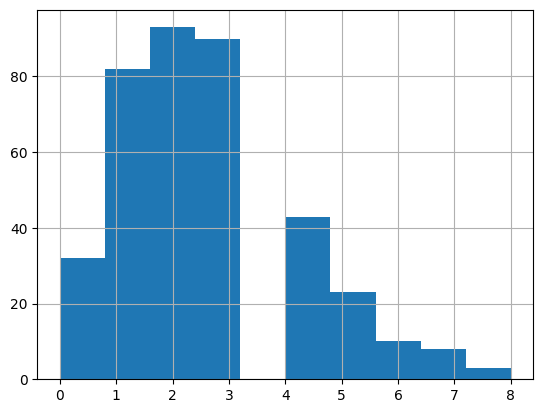

In [141]:
# Determine normality using histograms
men_subset["goals_scored"].hist()
plt.show()
# plt.clf()

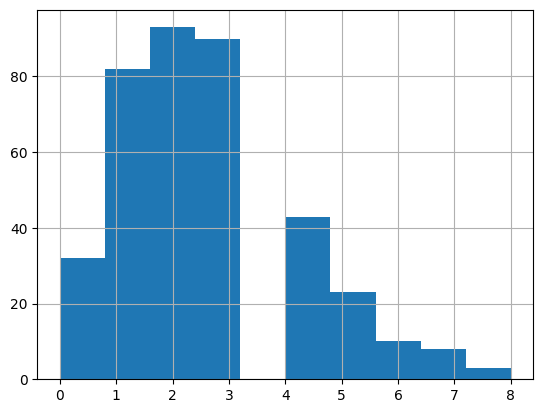

<Figure size 640x480 with 0 Axes>

In [142]:
# Goals scored is not normally distributed, so use Wilcoxon-Mann-Whitney test of two groups
men_subset["goals_scored"].hist()
plt.show()
plt.clf()

In [143]:
# Combine women's and men's data and calculate goals scored in each match
both = pd.concat([women_subset, men_subset], axis=0, ignore_index=True)
both.head()

,Unnamed: 0,date,home_team,away_team,home_score,away_score,tournament,group,goals_scored
0,1600,2003-09-20,Nigeria,North Korea,0,3,FIFA World Cup,women,3
1,1601,2003-09-20,Norway,France,2,0,FIFA World Cup,women,2
2,1602,2003-09-20,Germany,Canada,4,1,FIFA World Cup,women,5
3,1603,2003-09-20,Japan,Argentina,6,0,FIFA World Cup,women,6
4,1604,2003-09-21,United States,Sweden,3,1,FIFA World Cup,women,4


<AxesSubplot: xlabel='goals_scored', ylabel='count'>

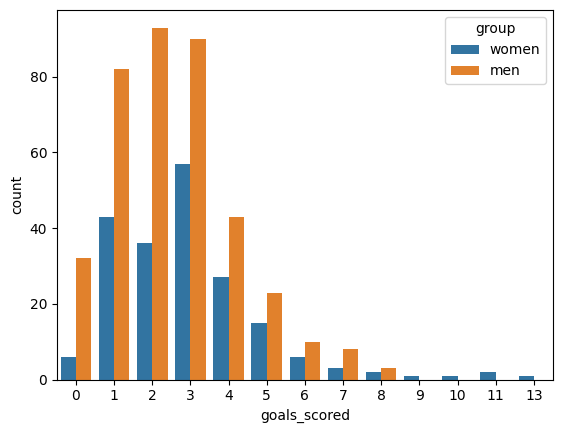

In [144]:
# sns.histplot(data=both, x="goals_scored", hue="group")
sns.countplot(x="goals_scored", data=both, hue='group')

In [145]:
# Optionally - confirm the histogram's output by conducting a normality test
# To choose between unpaired t-test and Wilcoxon-Mann-Whitney test
normality = pingouin.normality(
    data=both,
    dv='goals_scored',
    group='group',
    method='shapiro', # The Shapiro-Wilk test is used to assess normality
    alpha=0.05) # 0.05 is also the default
normality

,W,pval,normal
group,,,
women,0.849101,3.890520e-13,False
men,0.926649,8.894154e-13,False


In [146]:
# Transform the data for the pingouin Mann-Whitney U t-test/Wilcoxon-Mann-Whitney test
both_subset = both[["goals_scored", "group"]]
both_subset_wide = both_subset.pivot(columns="group", values="goals_scored")
both_subset_wide.head()

group,men,women
0,NaN,3.0
1,NaN,2.0
2,NaN,5.0
3,NaN,6.0
4,NaN,4.0


In [147]:
# Perform right-tailed Wilcoxon-Mann-Whitney test with pingouin
results_pg = pingouin.mwu(x=both_subset_wide["women"],
                          y=both_subset_wide["men"],
                          alternative="greater")
results_pg

,U-val,alternative,p-val,RBC,CLES
MWU,43273.0,greater,0.005107,-0.126901,0.563451


In [148]:
# Extract p-value as a float
p_val = results_pg["p-val"].values[0]

# Determine hypothesis test result using sig. level
if p_val <= 0.1:
    result = "reject"
else:
    result = "fail to reject"

result_dict = {"p_val": p_val, "result": result}
result_dict

{'p_val': 0.005106609825443641, 'result': 'reject'}